In [1]:
NAME = "Alasdair Breasley"
CIS_USERNAME = "fmcv76"

---

# COMP42415 Text Mining and Language Analytics
## Coursework 2023-24

### Instructions:

- <ins>**DO NOT RENAME THIS JUPYTER NOTEBOOK !!!**</ins>
- Please write the answers for each question in the respective cell. 
- You can add more cells if needed.
- If needed, you can upload additional files, e.g. pre-trained word embeddings, in the coursework's directory
- You can safely remove the `raise NotImplementedError()` line from each code cell.
- You can find information about markdown syntax from [here](https://www.markdownguide.org/basic-syntax/#emphasis).

In [2]:
# Import required packages 
import numpy as np
import pandas as pd
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer
nltk.download("averaged_perceptron_tagger")
from nltk import pos_tag
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score,precision_score, recall_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
sns.set() # Use seaborn plotting style
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import gensim
from gensim.models import Word2Vec
import ast
import pickle
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping


<ipython-input-2-437201391563>:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package stopwords to
[nltk_data]     /home3/fmcv76/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home3/fmcv76/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home3/fmcv76/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home3/fmcv76/nltk_data...
[nltk_data]   Package averaged_perc

In [3]:
# Controls 
percentage_subset = 0.25 # Proportion of dataset to use. Note: need to re run all to update through the different steps 
load_preprocessed_data = True # Load preprocessed data 
load_precalculated_w2v_embeddings_100 = True # Load precalculated Word2Vec 100 dimensional vector word representations 
load_precalculated_w2v_docs_vectorised = True # Load precalculated Word2Vec 100 dimensional vector document representations 
load_precalculated_w2v_embeddings_25 = True # Load precalculated Word2Vec 25 dimensional vector word representations 
load_precalculated_w2v_words_vectorised = True # Load precalculated Word2Vec 50 by 25 matrix document representations 

load_NB = True # Load pretrained Naive Bayes model 
run_kNN = True # Run k Nearest Neighbours model 
run_kNN_cross_validation = True # Run kNN cross-validation NOTE: This has been prerun with results loaded in so should 
# be False unless you want to wait a long time for this to run 
load_kNN = True # Load pretrained k Nearest Neighbours model 
load_CNN = True # Load pretrained Convolutional Neural Network model 
load_LSTM = True # Load pretrained Long Short-Term Memory model 


## Implementation - Task 1
Prepare the dataset by applying any pre-processing or cleaning steps that you consider as necessary. Then, split the dataset into a training set containing 70% of the samples and a test set containing 30% of the samples. Follow an appropriate strategy for the split. You must use these training/test sets for all the models in this coursework. (**10%**)

In [4]:
if (load_preprocessed_data != True):
    
    # Import food reviews data 
    food_reviews_data = pd.read_csv("food_reviews.csv")
    
    # Check dataframe head 
    print(food_reviews_data.head(5), "\n")
    
    # Check dataframe shape 
    print(food_reviews_data.shape, "\n")
    
    # Check data types 
    print(food_reviews_data.dtypes, "\n")
    
    # Check for missing values 
    print(food_reviews_data.isna().sum())
    
    # Check uniqueness of Score column 
    print(food_reviews_data["Score"].unique(), "\n")
    
    # Check for duplicate rows 
    print(food_reviews_data[food_reviews_data.duplicated()].shape[0], "\n")
    
    # Remove duplicate rows 
    food_reviews_data = food_reviews_data.drop_duplicates()
    
    # Recheck dataframe shape 
    print(food_reviews_data.shape, "\n")
    
    # Concatenate Summary column with Text column to capture all available information 
    food_reviews_data["Text"] = food_reviews_data["Summary"].astype(str) + " " + food_reviews_data["Text"].astype(str)
    
    # Check how many rows contain html tags 
    print(food_reviews_data["Text"].str.contains(r"<.+?>").sum(), "\n")
    
    # Replace html tags with " ", " " as opposed to "" to not join words unintentionally 
    food_reviews_data["Text"] = food_reviews_data["Text"].str.replace(r"<.+?>", " ", regex = True)
    
    # Recheck how many rows contain html tags 
    print(food_reviews_data["Text"].str.contains(r"<.+?>").sum(), "\n")
    
    # Transform Text column to all lowercase 
    food_reviews_data["Text"] = food_reviews_data["Text"].str.lower()
    
    # Remove all "-", ".", "'" and replace with "" e.g. lower-case to lowercase, U.K to UK, don't to dont 
    food_reviews_data["Text"] = food_reviews_data["Text"].str.replace(r"[-.']", "", regex = True)
    
    # Check how many rows include happy or sad text emojis 
    print(food_reviews_data["Text"].str.contains(r"[:][)]|[:][(]|[)][:]|[(][:]").sum(), "\n")
    
    # Replace happy emojis with " happy " 
    food_reviews_data["Text"] = food_reviews_data["Text"].str.replace(r"[:][)]|[(][:]", " happy ", regex = True)
    
    # Replace sad emojis with " sad " 
    food_reviews_data["Text"] = food_reviews_data["Text"].str.replace(r"[:][(]|[)][:]", " sad ", regex = True)
    
    # Recheck how many rows include happy or sad text emojis 
    print(food_reviews_data["Text"].str.contains(r"[:][)]|[:][(]|[)][:]|[(][:]").sum(), "\n")
    
    # Check how many rows include punctuation 
    print(food_reviews_data["Text"].str.contains(r"[^\w\s]").sum(), "\n")

    # Remove punctuation 
    food_reviews_data["Text"] = food_reviews_data["Text"].str.replace(r"[^\w\s]", " ", regex = True)
    
    # Recheck how many rows include punctuation 
    print(food_reviews_data["Text"].str.contains(r"[^\w\s]").sum(), "\n")
    
    # Check for class imbalance 
    print(food_reviews_data["Score"].value_counts(), "\n")
    
    # There is class imbalance present 
    
    # Check dataframe head 
    print(food_reviews_data.head(5), "\n")
    
    # Stratified random sample to get subset of the total data 25% of each Score class 
    food_reviews_data = food_reviews_data.groupby("Score", group_keys = False).apply(lambda x: x.sample(frac = percentage_subset))


In [5]:
def penn_to_wordnet(penn_pos_tag):
    """Function to convert Penn Treeback POS tags to WordNet."""
    
    tag_dictionary = {"NN":"n", "JJ":"a","VB":"v", "RB":"r"}
    
    try:
        
        # If the first two characters of the Penn Treebank POS tag are in the tag_dictionary 
        return tag_dictionary[penn_pos_tag[:2]]
    
    except:
        
        return "n" # Default to Noun if no mapping available 
    

# Get list of English stop words - Define outside of function so doesn't have to process every call 
stopwords_english = stopwords.words("english")


def remove_stopwords_and_lemmatise(text):
    """Function to tokenise a string, remove stop words, lemmatise, and return a list of words."""
    
    # Check text input is a string 
    if (not isinstance(text, str)):
        
        raise Exception("text input is not a string.")
    
    # Tokenise text into words 
    words = word_tokenize(text)
    
    # Remove stop words 
    words_filtered = [word for word in words if word not in stopwords_english]
    
    # Apply POS tagging 
    words_pos_tagged = pos_tag(words_filtered)
    
    # Create a WordNetLemmatizer object 
    wnl = WordNetLemmatizer()
    
    # Define empty lemmas list 
    lemmas = []
    
    # Loop through words in sentence and lemmatise 
    for word, tag in words_pos_tagged:
        
        lemmas.append(wnl.lemmatize(word, pos = penn_to_wordnet(tag)))
    
    return lemmas
    

In [6]:
if (load_preprocessed_data != True):
        
    # Split data into training (70%) and test (30%) splits 
    train_data, test_data, train_labels, test_labels = train_test_split(food_reviews_data["Text"], food_reviews_data["Score"], 
                                                                        test_size = 0.3, random_state = 123, 
                                                                        stratify = food_reviews_data["Score"])
    
    food_reviews_data = None
    
    train_labels = train_labels.tolist()
    
    test_labels = test_labels.tolist()
    
    # Remove stop words from train data and lemmatise 
    train_data_tokenised = train_data.apply(remove_stopwords_and_lemmatise)
    
    # Join lists of lemmas to string (need both ways) 
    train_data = [" ".join(lemmas) for lemmas in train_data_tokenised]
    
    # Remove stop words from test data and lemmatise 
    test_data_tokenised = test_data.apply(remove_stopwords_and_lemmatise)
    
    # Join lists of lemmas to string (need both ways) 
    test_data = [" ".join(lemmas) for lemmas in test_data_tokenised]
    
    # Save tokenised train data to csv 
    train_data_tokenised_csv = pd.Series(train_data_tokenised)
    train_data_tokenised_csv.to_csv("train_data_tokenised_1.csv")
    
    # Save train data to csv 
    train_data_csv = pd.DataFrame({"Text" : train_data, 
                                   "Score" : train_labels})
    train_data_csv.to_csv("train_data_1.csv")
    
    # Save tokenised test data to csv 
    test_data_tokenised_csv = pd.Series(test_data_tokenised)
    test_data_tokenised_csv.to_csv("test_data_tokenised_1.csv")
    
    # Save test data to csv 
    test_data_csv = pd.DataFrame({"Text" : test_data, 
                                  "Score" : test_labels})
    test_data_csv.to_csv("test_data_1.csv")
    
if (load_preprocessed_data == True):
    
    # Load preprocessed tokenised train data 
    train_data_tokenised = pd.read_csv("train_data_tokenised_1.csv", index_col = 0)["Text"].tolist()
    train_data_tokenised = [ast.literal_eval(text) for text in train_data_tokenised]
    
    # Load preprocessed train data 
    train_data = pd.read_csv("train_data_1.csv", index_col = 0)["Text"].tolist()
    
    # Load train labels 
    train_labels = pd.read_csv("train_data_1.csv", index_col = 0)["Score"].tolist()
    
    # Load preprocessed tokenised test data 
    test_data_tokenised = pd.read_csv("test_data_tokenised_1.csv", index_col = 0)["Text"].tolist()
    test_data_tokenised = [ast.literal_eval(text) for text in test_data_tokenised]
    
    # Load preprocessed test data 
    test_data = pd.read_csv("test_data_1.csv", index_col = 0)["Text"].tolist()
    
    # Load test labels 
    test_labels = pd.read_csv("test_data_1.csv", index_col = 0)["Score"].tolist()


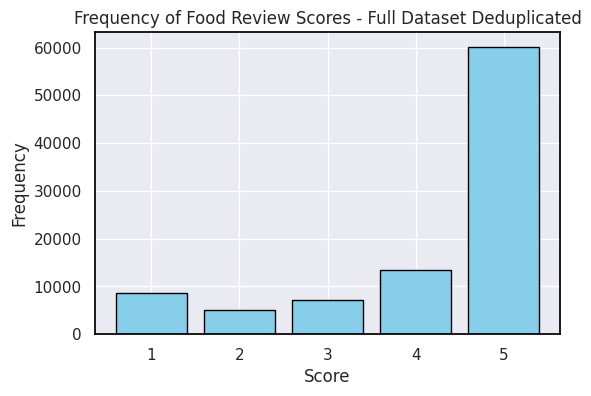

In [7]:
# Visualise the frequency of Score values for the entire dataset 
all_scores = pd.Series(train_labels + test_labels)
all_frequencies = all_scores.value_counts()
all_frequencies = all_frequencies.reset_index()
all_frequencies.columns = ["Score", "Frequency"]

plt.figure(figsize = (6, 4), dpi = 100)
plt.bar(all_frequencies["Score"], all_frequencies["Frequency"], color = "skyblue", edgecolor = "black")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Frequency of Food Review Scores - Full Dataset Deduplicated")
ax = plt.gca()
ax.spines["top"].set_color("black")
ax.spines["right"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["bottom"].set_color("black")
plt.savefig("Figure_1_1.png")
plt.show()


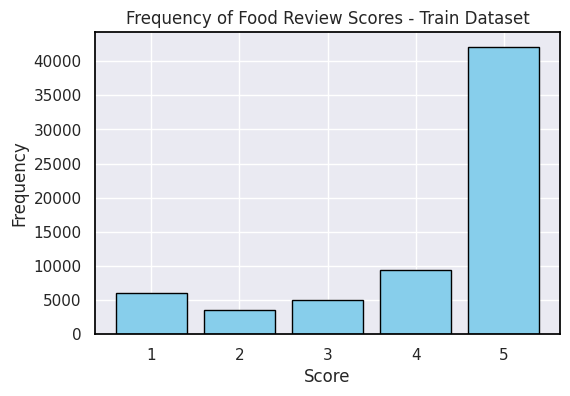

In [8]:
# Visualise the frequency of Score values for the train dataset 
train_scores = pd.Series(train_labels)
train_frequencies = train_scores.value_counts()
train_frequencies = train_frequencies.reset_index()
train_frequencies.columns = ["Score", "Frequency"]

plt.figure(figsize = (6, 4), dpi = 100)
plt.bar(train_frequencies["Score"], train_frequencies["Frequency"], color = "skyblue", edgecolor = "black")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Frequency of Food Review Scores - Train Dataset")
ax = plt.gca()
ax.spines["top"].set_color("black")
ax.spines["right"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["bottom"].set_color("black")
plt.show()


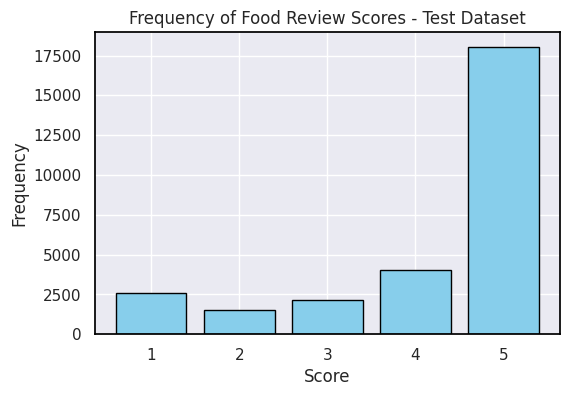

In [9]:
# Visualise the frequency of Score values for the test dataset 
test_scores = pd.Series(test_labels)
test_frequencies = test_scores.value_counts()
test_frequencies = test_frequencies.reset_index()
test_frequencies.columns = ["Score", "Frequency"]

plt.figure(figsize = (6, 4), dpi = 100)
plt.bar(test_frequencies["Score"], test_frequencies["Frequency"], color = "skyblue", edgecolor = "black")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Frequency of Food Review Scores - Test Dataset")
ax = plt.gca()
ax.spines["top"].set_color("black")
ax.spines["right"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["bottom"].set_color("black")
plt.show()


## Implementation - Task 2
Implement a Naïve Bayes model for predicting the rating of a food review. Train your model on the training set and test it on the test set. Use an appropriate text representation. (**5%**)

In [10]:
if (load_NB != True):
    
    # Naive Bayes model - input is converted to TF-IDF vectors and then Multinomial Naive Bayes is used 
    nb_model = make_pipeline(TfidfVectorizer(), MultinomialNB())
    
    # Tune model for best value of alpha (lapace smoothing parameter) using 5-fold cross-validation 
    # More coarse grid searching was undertaken initially to narrow down to the below range 
    grid = {"multinomialnb__alpha" : [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]}
    
    grid_search = GridSearchCV(nb_model, grid, cv = 5, scoring = "accuracy")
    
    grid_search.fit(train_data, train_labels)
    
    best_alpha = grid_search.best_params_["multinomialnb__alpha"]
    
    print(best_alpha)
    
    nb_model.set_params(multinomialnb__alpha = best_alpha)
    
    # Train model 
    nb_model.fit(train_data, train_labels)
    
    # Save model 
    nb_model_filename = "nb_model_1.pkl"
    
    with open(nb_model_filename, "wb") as file:
        
        pickle.dump(nb_model, file)

if (load_NB == True):
    
    # Load model 
    with open("nb_model_1.pkl", "rb") as file:
        
        nb_model = pickle.load(file)
    
# Test model 
nb_predictions = nb_model.predict(test_data)


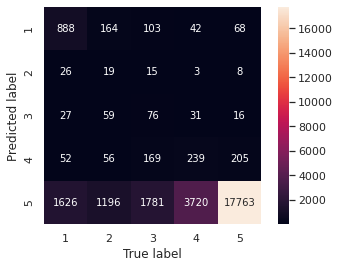

Accuracy:	0.669618
F1-score:	0.290277
Precision:	0.469128
Recall:		0.286003

Classification performance:
              precision    recall  f1-score   support

           1       0.70      0.34      0.46      2619
           2       0.27      0.01      0.02      1494
           3       0.36      0.04      0.06      2144
           4       0.33      0.06      0.10      4035
           5       0.68      0.98      0.80     18060

    accuracy                           0.67     28352
   macro avg       0.47      0.29      0.29     28352
weighted avg       0.59      0.67      0.58     28352



In [11]:
# Plot the confusion matrix
score_catagory_labels = [1, 2, 3, 4, 5]

matrix = confusion_matrix(test_labels, nb_predictions)
sns.heatmap(matrix.T, square = True, annot = True, fmt = "d", 
           xticklabels = score_catagory_labels, yticklabels = score_catagory_labels)
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_labels, nb_predictions))
print("F1-score:\t%f" % f1_score(test_labels, nb_predictions, average = "macro"))
print("Precision:\t%f" % precision_score(test_labels, nb_predictions, average = "macro"))
print("Recall:\t\t%f" % recall_score(test_labels, nb_predictions, average = "macro"))
print("\nClassification performance:\n%s" % classification_report(test_labels, nb_predictions))


## Implementation - Task 3
Implement a k-Nearest Neighbours model for predicting the rating of a food review. Train your model on the training set and test it on the test set. Use an appropriate text representation. You must select the best k by examining the performance of the model for $k \in \{1,3,5,7\}$, using an appropriate cross-validation approach. Create a plot for k vs. classification performance to justify your choice. (**10%**)

In [12]:
if (load_precalculated_w2v_embeddings_100 != True):
    
    # Train word2vec word embedding model using train data to create denser vectors  
    w2v_word_embeddings_100 = gensim.models.Word2Vec(train_data_tokenised, vector_size = 100, window = 5, 
                                                 min_count = 1, sg = 0, seed = 123)
        
    # Save word2vec word embeddings 
    w2v_word_embeddings_100.save("w2v_word_embeddings_100.model")

if (load_precalculated_w2v_embeddings_100 == True):
    
    # Load word2vec word embeddings 
    w2v_word_embeddings_100 = Word2Vec.load("w2v_word_embeddings_100.model")
    

def text_to_single_vector(text, w2v_word_embeddings):
    """Function to trasform document (a review) in the form of a list of words into a single vector 
    representation which is the average vector representation of the embedded words in the review."""
    
    # Check text input is a list  
    if (not isinstance(text, list)):
        
        raise Exception("text input is not a list.")
    
    # Average word representations to get document representation ensuring to only divide by the number of words 
    # for which representations exist from the training data 
    vector = sum(w2v_word_embeddings.wv[word] for word in text if word in w2v_word_embeddings.wv) / len([word for word in text if word in w2v_word_embeddings.wv])
    
    return vector


if (load_precalculated_w2v_docs_vectorised != True):
    
    # Vectorise train data into dense vector document representations 
    train_data_w2v_docs_vectorised = [text_to_single_vector(text, w2v_word_embeddings_100) for text in train_data_tokenised]
    
    # Vectorise test data into dense vector document representations 
    test_data_w2v_docs_vectorised = [text_to_single_vector(text, w2v_word_embeddings_100) for text in test_data_tokenised]
    
    # Save vectorised document representations 
    with open("train_data_w2v_docs_vectorised_1.pkl", "wb") as file:
        
        pickle.dump(train_data_w2v_docs_vectorised, file)
        
    # Save vectorised document representations 
    with open("test_data_w2v_docs_vectorised_1.pkl", "wb") as file:
        
        pickle.dump(test_data_w2v_docs_vectorised, file)
        
if (load_precalculated_w2v_docs_vectorised == True):
    
    # Load vectorised document representations 
    with open("train_data_w2v_docs_vectorised_1.pkl", "rb") as file:
    
        train_data_w2v_docs_vectorised = pickle.load(file)
    
    # Load vectorised document representations 
    with open("test_data_w2v_docs_vectorised_1.pkl", "rb") as file:
    
        test_data_w2v_docs_vectorised = pickle.load(file)
    
if (run_kNN == True):
    
    if (run_kNN_cross_validation == True):
        
        # Values of k to test 
        k_values = [1, 3, 5, 7]
        
        mean_accuracies = []
        
        for k in k_values:
            
            # Initiate a kNN model for each k 
            knn_model = KNeighborsClassifier(n_neighbors = k)
            
            # Cross-validate each kNN model 
            scores = cross_val_score(knn_model, train_data_w2v_docs_vectorised, train_labels, cv = 5, scoring = "accuracy")
            
            # Get the average accuracy for each model from cross-validation 
            mean_accuracy = scores.mean()
            
            mean_accuracies.append(mean_accuracy)
            
        # Save cross-validation accuracies  
        with open("knn_mean_accuracies_1.pkl", "wb") as file:
            
            pickle.dump(mean_accuracies, file)
            
    if (run_kNN_cross_validation != True):
        
        # Load cross-validation accuracies  
        with open("knn_mean_accuracies_1.pkl", "rb") as file:
            
            mean_accuracies = pickle.load(file)
    

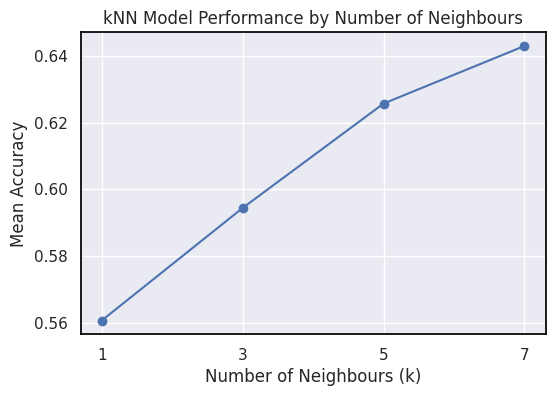

In [13]:
if (run_kNN):
    
    k_values = [1, 3, 5, 7]
    
    # Plot kNN model performance for each k tested 
    plt.figure(figsize = (6, 4), dpi = 100)
    plt.plot(k_values, mean_accuracies, marker = "o", linestyle = "-", color = "b")
    plt.title("kNN Model Performance by Number of Neighbours")
    plt.xlabel("Number of Neighbours (k)")
    plt.ylabel("Mean Accuracy")
    plt.xticks(k_values)
    plt.grid(True)
    ax = plt.gca()
    ax.spines["top"].set_color("black")
    ax.spines["right"].set_color("black")
    ax.spines["left"].set_color("black")
    ax.spines["bottom"].set_color("black")
    plt.savefig("Figure_2_1.png")
    plt.show()


In [14]:
if (run_kNN == True):
    
    if (load_kNN != True):
        
        k_values = [1, 3, 5, 7]
        
        # k Nearest Neighbours model - input is converted to TF-IDF vectors and then kNN is used 
        # The k value which produced the hgihest accuracy from cross-validation on the train/validation set is used 
        knn_model = KNeighborsClassifier(n_neighbors = k_values[mean_accuracies.index(max(mean_accuracies))])
        
        # Train model 
        knn_model.fit(train_data_w2v_docs_vectorised, train_labels)
        
        # Save model 
        knn_model_filename = "knn_model_1.pkl"
        
        with open(knn_model_filename, "wb") as file:
            
            pickle.dump(knn_model, file)
            
    if (load_kNN == True):
        
        # Load model 
        with open("knn_model_1.pkl", "rb") as file:
            
            knn_model = pickle.load(file)
            
    # Test model 
    knn_predictions = knn_model.predict(test_data_w2v_docs_vectorised)


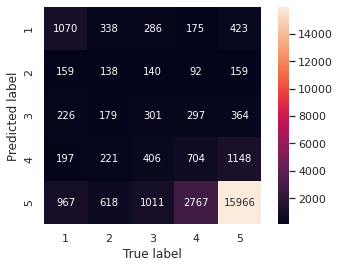

Accuracy:	0.641189
F1-score:	0.350839
Precision:	0.379850
Recall:		0.339968

Classification performance:
              precision    recall  f1-score   support

           1       0.47      0.41      0.44      2619
           2       0.20      0.09      0.13      1494
           3       0.22      0.14      0.17      2144
           4       0.26      0.17      0.21      4035
           5       0.75      0.88      0.81     18060

    accuracy                           0.64     28352
   macro avg       0.38      0.34      0.35     28352
weighted avg       0.58      0.64      0.61     28352



In [15]:
if (run_kNN == True):
    
    # Plot the confusion matrix
    score_catagory_labels = [1, 2, 3, 4, 5]
    
    matrix = confusion_matrix(test_labels, knn_predictions)
    sns.heatmap(matrix.T, square = True, annot = True, fmt = "d", 
                xticklabels = score_catagory_labels, yticklabels = score_catagory_labels)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    plt.show()
    
    # Compute and print classification performance metrics
    print("Accuracy:\t%f" % accuracy_score(test_labels, knn_predictions))
    print("F1-score:\t%f" % f1_score(test_labels, knn_predictions, average = "macro"))
    print("Precision:\t%f" % precision_score(test_labels, knn_predictions, average = "macro"))
    print("Recall:\t\t%f" % recall_score(test_labels, knn_predictions, average = "macro"))
    print("\nClassification performance:\n%s" % classification_report(test_labels, knn_predictions))


## Implementation - Task 4
Implement a Convolutional Neural Network (CNN) model for predicting the rating of a food review. The model must have at least two convolutional layers. Train your model on the training set and test it on the test set. Use an appropriate text representation. (**13%**)

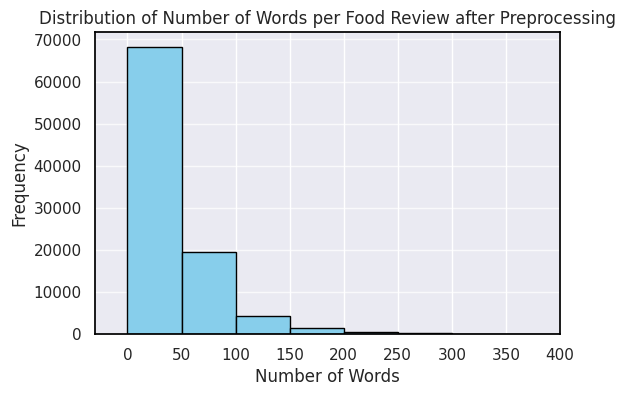

Note: y axis limited to show only visible columns. Number of words values go as high as 1974.


In [16]:
# Calculate the number of words in each review after preprocessing etc. 
all_data_tokenised = train_data_tokenised + test_data_tokenised

n_words = [len(text) for text in all_data_tokenised]

# Summary statistics for the number of words per review 
pd.Series(n_words).describe()

# Plot the number of words per food review 
plt.figure(figsize = (6, 4), dpi = 100)
plt.hist(n_words, bins = range(0, 2100, 50), color = "skyblue", edgecolor = "black")
plt.title("Distribution of Number of Words per Food Review after Preprocessing")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(axis = "y", alpha = 0.75)
plt.xlim([-30, 400])
ax = plt.gca()
ax.spines["top"].set_color("black")
ax.spines["right"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["bottom"].set_color("black")
plt.savefig("Figure_3_1.png")
plt.show()

max_words = round(pd.Series(n_words).describe()["max"])
print(f"Note: y axis limited to show only visible columns. Number of words values go as high as {max_words}.")


In [17]:
def document_to_matrix(document, w2v_word_embeddings, max_length):
    """Function to trasform document (a review) in the form of a list of words into a matrix of 
    vector representations, until the specified max length."""
    
    # Initiate empty matrix 
    matrix = np.zeros((max_length, 25))
    
    # Loop through each word in the document and if it has vector representation from the training data add to matrix 
    for i, word in enumerate(document):
        
        if i >= max_length:
            
            break
            
        if word in w2v_word_embeddings.wv:
            
            matrix[i] = w2v_word_embeddings.wv[word]
            
    return matrix
    
    
if (load_precalculated_w2v_embeddings_25 != True):
    
    # Train word2vec word embedding model using train data to create denser vectors  
    w2v_word_embeddings_25 = gensim.models.Word2Vec(train_data_tokenised, vector_size = 25, window = 5, 
                                                    min_count = 1, sg = 0, seed = 123)
        
    # Save word2vec word embeddings 
    w2v_word_embeddings_25.save("w2v_word_embeddings_25.model")

if (load_precalculated_w2v_embeddings_25 == True):
    
    # Load word2vec word embeddings 
    w2v_word_embeddings_25 = Word2Vec.load("w2v_word_embeddings_25.model")
    

In [18]:
if (load_precalculated_w2v_words_vectorised != True):
    
    # Vectorise train data into dense vector word representations and combine into a 
    # list of dense matrix document representations
    train_data_w2v_words_vectorised = [document_to_matrix(text, w2v_word_embeddings_25, 50) for text in train_data_tokenised]
    
    # Vectorise test data into dense vector word representations and combine into a 
    # list of dense matrix document representations
    test_data_w2v_words_vectorised = [document_to_matrix(text, w2v_word_embeddings_25, 50) for text in test_data_tokenised]
    
    # Save vectorised word representations 
    with open("train_data_w2v_words_vectorised_25_1.pkl", "wb") as file:
        
        pickle.dump(train_data_w2v_words_vectorised, file)
        
    # Save vectorised word representations 
    with open("test_data_w2v_words_vectorised_25_1.pkl", "wb") as file:
        
        pickle.dump(test_data_w2v_words_vectorised, file)

if (load_precalculated_w2v_words_vectorised == True):
    
    if ((load_CNN != True) or (load_LSTM != True)):
        
        # Load vectorised word representations 
        with open("train_data_w2v_words_vectorised_25_1.pkl", "rb") as file:
        
            train_data_w2v_words_vectorised = pickle.load(file)
    
    # Load vectorised word representations 
    with open("test_data_w2v_words_vectorised_25_1.pkl", "rb") as file:
    
        test_data_w2v_words_vectorised = pickle.load(file)
        

In [19]:
if (load_CNN != True):
    
    # CNN model architecture 
    embedding_size = (50, 25)
    optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0002)
    
    cnn_model = models.Sequential()
    
    cnn_model.add(layers.Conv1D(filters = 128, kernel_size = 5, activation = "relu", input_shape = embedding_size))
    cnn_model.add(layers.MaxPooling1D(pool_size = 5))
    cnn_model.add(layers.Conv1D(filters = 128, kernel_size = 5, activation = "relu"))
    cnn_model.add(layers.GlobalMaxPooling1D())
    cnn_model.add(layers.Dense(units = 128, activation = "relu"))
    cnn_model.add(layers.Dense(5, activation = "softmax"))
    
    cnn_model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimiser, metrics = ["accuracy"])


In [20]:
# Zero index score labels for CNN 
train_labels_minus1 = [score - 1 for score in train_labels]

test_labels_minus1 = [score - 1 for score in test_labels]

if (load_CNN != True):
    
    epochs = 20
    
    # Early stopping condition 
    early = EarlyStopping(monitor = "val_accuracy", patience = 3, restore_best_weights = True, mode = "auto")
    
    x_train = np.array(train_data_w2v_words_vectorised)
    y_train = np.array(train_labels_minus1)
    
    cnn_history = cnn_model.fit(x = x_train, y = y_train, validation_split = 0.3, epochs = epochs, callbacks = [early], verbose = 2)
    


In [21]:
if (load_CNN != True):
    
    # Save model 
    cnn_model_filename = "cnn_model_4_1.pkl"
    
    with open(cnn_model_filename, "wb") as file:
        
        pickle.dump(cnn_model, file)
        
    # Save training history 
    cnn_model_history_filename = "cnn_model_history_4_1.pkl"
    
    with open(cnn_model_history_filename, "wb") as file:
        
        pickle.dump(cnn_history, file)
        

In [22]:
if (load_CNN == True):
    
    # Load model 
    with open("cnn_model_4_1.pkl", "rb") as file:
        
        cnn_model = pickle.load(file)
        
    # Load training history 
    with open("cnn_model_history_4_1.pkl", "rb") as file:
        
        cnn_history = pickle.load(file)
        

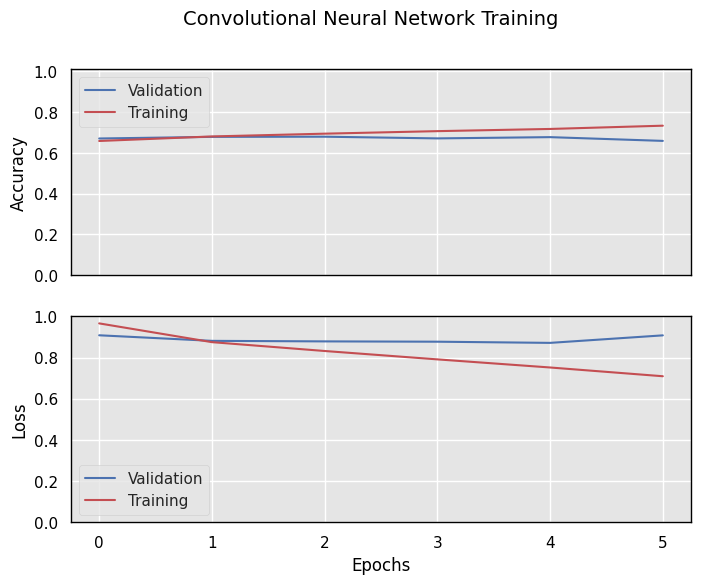

In [23]:
# Plot CNN training 
plt.style.use("ggplot")
fig, (ax1, ax2) = plt.subplots(2, figsize = (8, 6), dpi = 100, sharex = True)
fig.suptitle("Convolutional Neural Network Training", fontsize = 14, color = "black")
ax1.set_ylim([0, 1.01])
ax1.plot(cnn_history.history["val_accuracy"], "b")
ax1.set_ylabel("Accuracy", color = "black")
ax1.plot(cnn_history.history["accuracy"], "r")
ax1.legend(["Validation", "Training"])
ax1.spines["top"].set_color("black")
ax1.spines["right"].set_color("black")
ax1.spines["left"].set_color("black")
ax1.spines["bottom"].set_color("black")
ax1.tick_params(axis = "x", colors = "black")
ax1.tick_params(axis = "y", colors = "black")
ax2.set_ylim([0, 1])
ax2.plot(cnn_history.history["val_loss"], "b")
ax2.plot(cnn_history.history["loss"], "r")
ax2.set_ylabel("Loss", color = "black")
ax2.set_xlabel("Epochs", color = "black")
ax2.legend(["Validation", "Training"])
ax2.spines["top"].set_color("black")
ax2.spines["right"].set_color("black")
ax2.spines["left"].set_color("black")
ax2.spines["bottom"].set_color("black")
ax2.tick_params(axis = "x", colors = "black")
ax2.tick_params(axis = "y", colors = "black")
plt.savefig("Figure_4_1.png")
plt.show()


In [24]:
# Test model 
cnn_predictions = cnn_model.predict(np.array(test_data_w2v_words_vectorised))

cnn_predictions_labels = np.argmax(cnn_predictions, axis = 1)


886/886 [==============================] - 2s 2ms/step


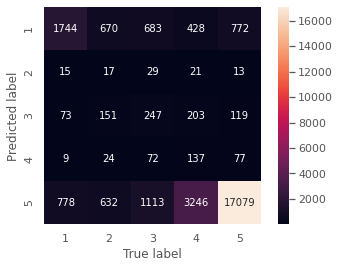

Accuracy:	0.678047
F1-score:	0.318372
Precision:	0.414652
Recall:		0.354424

Classification performance:
              precision    recall  f1-score   support

           0       0.41      0.67      0.50      2619
           1       0.18      0.01      0.02      1494
           2       0.31      0.12      0.17      2144
           3       0.43      0.03      0.06      4035
           4       0.75      0.95      0.83     18060

    accuracy                           0.68     28352
   macro avg       0.41      0.35      0.32     28352
weighted avg       0.61      0.68      0.60     28352



In [25]:
# Plot the confusion matrix 
score_catagory_labels = [1, 2, 3, 4, 5]

matrix = confusion_matrix(test_labels_minus1, cnn_predictions_labels)
sns.heatmap(matrix.T, square = True, annot = True, fmt = "d", 
            xticklabels = score_catagory_labels, yticklabels = score_catagory_labels)
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_labels_minus1, cnn_predictions_labels))
print("F1-score:\t%f" % f1_score(test_labels_minus1, cnn_predictions_labels, average = "macro"))
print("Precision:\t%f" % precision_score(test_labels_minus1, cnn_predictions_labels, average = "macro"))
print("Recall:\t\t%f" % recall_score(test_labels_minus1, cnn_predictions_labels, average = "macro"))
print("\nClassification performance:\n%s" % classification_report(test_labels_minus1, cnn_predictions_labels))


## Implementation - Task 5
Implement a Recurrent Neural Network (RNN) or a Long Short-Term Memory (LSTM) model for predicting the rating of a food review. The model must have at least two RNN/LSTM layers. Train your model on the training set and test it on the test set. Use an appropriate text representation. (**12%**)

In [26]:
if (load_LSTM != True):
    
    # LSTM model architecture 
    embedding_size = (50, 25)
    optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0002)
    
    lstm_model = models.Sequential()
    
    lstm_model.add(layers.Masking(mask_value = 0., input_shape = embedding_size))
    lstm_model.add(layers.Bidirectional(layers.LSTM(units = 64, return_sequences = True)))
    lstm_model.add(layers.Bidirectional(layers.LSTM(units = 64, go_backwards = True, dropout = 0.2)))
    lstm_model.add(layers.Dense(units = 64, activation = "relu"))
    lstm_model.add(layers.Dense(5, activation = "softmax"))
    
    lstm_model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimiser, metrics = ["accuracy"])

# Zero index score labels for LSTM 
train_labels_minus1 = [score - 1 for score in train_labels]

test_labels_minus1 = [score - 1 for score in test_labels]

if (load_LSTM != True):
    
    epochs = 20
    
    # Early stopping condition 
    early = EarlyStopping(monitor = "val_accuracy", patience = 3, restore_best_weights = True, mode = "auto")
    
    x_train = np.array(train_data_w2v_words_vectorised)
    y_train = np.array(train_labels_minus1)
    
    lstm_history = lstm_model.fit(x = x_train, y = y_train, validation_split = 0.3, epochs = epochs, callbacks = [early], verbose = 2)
    
    # Save model 
    lstm_model_filename = "lstm_model_3_1.pkl"
    
    with open(lstm_model_filename, "wb") as file:
        
        pickle.dump(lstm_model, file)
        
    # Save training history 
    lstm_model_history_filename = "lstm_model_history_3_1.pkl"
    
    with open(lstm_model_history_filename, "wb") as file:
        
        pickle.dump(lstm_history, file)
        
if (load_LSTM == True):
    
    # Load model 
    with open("lstm_model_3_1.pkl", "rb") as file:
        
        lstm_model = pickle.load(file)
        
    # Load training history 
    with open("lstm_model_history_3_1.pkl", "rb") as file:
        
        lstm_history = pickle.load(file)
        

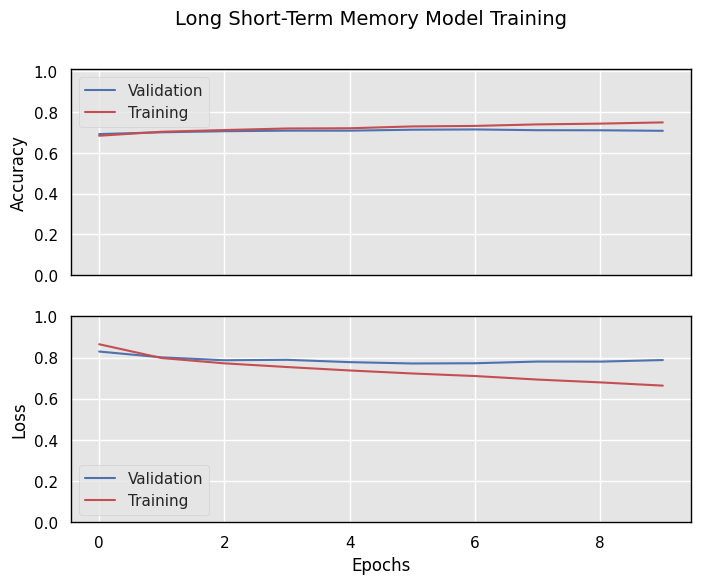

In [27]:
# Plot LSTM training 
plt.style.use("ggplot")
fig, (ax1, ax2) = plt.subplots(2, figsize = (8, 6), dpi = 100, sharex = True)
fig.suptitle("Long Short-Term Memory Model Training", fontsize = 14, color = "black")
ax1.set_ylim([0, 1.01])
ax1.plot(lstm_history.history["val_accuracy"], "b")
ax1.set_ylabel("Accuracy", color = "black")
ax1.plot(lstm_history.history["accuracy"], "r")
ax1.legend(["Validation", "Training"])
ax1.spines["top"].set_color("black")
ax1.spines["right"].set_color("black")
ax1.spines["left"].set_color("black")
ax1.spines["bottom"].set_color("black")
ax1.tick_params(axis = "x", colors = "black")
ax1.tick_params(axis = "y", colors = "black")
ax2.set_ylim([0, 1])
ax2.plot(lstm_history.history["val_loss"], "b")
ax2.plot(lstm_history.history["loss"], "r")
ax2.set_ylabel("Loss", color = "black")
ax2.set_xlabel("Epochs", color = "black")
ax2.legend(["Validation", "Training"])
ax2.spines["top"].set_color("black")
ax2.spines["right"].set_color("black")
ax2.spines["left"].set_color("black")
ax2.spines["bottom"].set_color("black")
ax2.tick_params(axis = "x", colors = "black")
ax2.tick_params(axis = "y", colors = "black")
plt.savefig("Figure_5_1.png")
plt.show()


In [28]:
# Test model 
lstm_predictions = lstm_model.predict(np.array(test_data_w2v_words_vectorised))

lstm_predictions_labels = np.argmax(lstm_predictions, axis = 1)


886/886 [==============================] - 19s 18ms/step


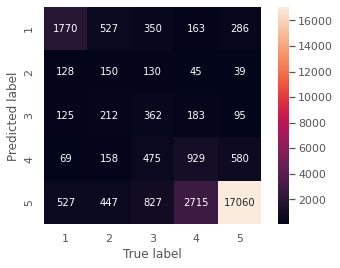

Accuracy:	0.714976
F1-score:	0.432152
Precision:	0.491594
Recall:		0.423988

Classification performance:
              precision    recall  f1-score   support

           0       0.57      0.68      0.62      2619
           1       0.30      0.10      0.15      1494
           2       0.37      0.17      0.23      2144
           3       0.42      0.23      0.30      4035
           4       0.79      0.94      0.86     18060

    accuracy                           0.71     28352
   macro avg       0.49      0.42      0.43     28352
weighted avg       0.66      0.71      0.67     28352



In [29]:
# Plot the confusion matrix 
score_catagory_labels = [1, 2, 3, 4, 5]

matrix = confusion_matrix(test_labels_minus1, lstm_predictions_labels)
sns.heatmap(matrix.T, square = True, annot = True, fmt = "d", 
            xticklabels = score_catagory_labels, yticklabels = score_catagory_labels)
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_labels_minus1, lstm_predictions_labels))
print("F1-score:\t%f" % f1_score(test_labels_minus1, lstm_predictions_labels, average = "macro"))
print("Precision:\t%f" % precision_score(test_labels_minus1, lstm_predictions_labels, average = "macro"))
print("Recall:\t\t%f" % recall_score(test_labels_minus1, lstm_predictions_labels, average = "macro"))
print("\nClassification performance:\n%s" % classification_report(test_labels_minus1, lstm_predictions_labels))


## Implementation - Task 6
Compute the confusion matrix, accuracy, F1-score, precision and recall for each model. (10%)

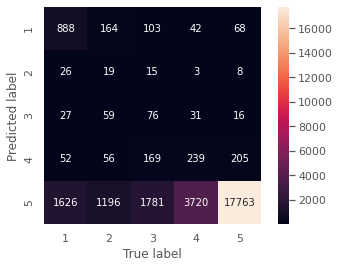

Accuracy:	0.669618
F1-score:	0.290277
Precision:	0.469128
Recall:		0.286003

Classification performance:
              precision    recall  f1-score   support

           1       0.70      0.34      0.46      2619
           2       0.27      0.01      0.02      1494
           3       0.36      0.04      0.06      2144
           4       0.33      0.06      0.10      4035
           5       0.68      0.98      0.80     18060

    accuracy                           0.67     28352
   macro avg       0.47      0.29      0.29     28352
weighted avg       0.59      0.67      0.58     28352



In [30]:
# Naive Bayes 

# Plot the confusion matrix
score_catagory_labels = [1, 2, 3, 4, 5]

matrix = confusion_matrix(test_labels, nb_predictions)
sns.heatmap(matrix.T, square = True, annot = True, fmt = "d", 
           xticklabels = score_catagory_labels, yticklabels = score_catagory_labels)
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.savefig("Figure_6_1.png")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_labels, nb_predictions))
print("F1-score:\t%f" % f1_score(test_labels, nb_predictions, average = "macro"))
print("Precision:\t%f" % precision_score(test_labels, nb_predictions, average = "macro"))
print("Recall:\t\t%f" % recall_score(test_labels, nb_predictions, average = "macro"))
print("\nClassification performance:\n%s" % classification_report(test_labels, nb_predictions))


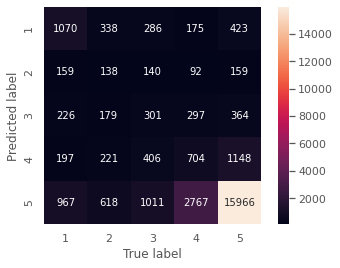

Accuracy:	0.641189
F1-score:	0.350839
Precision:	0.379850
Recall:		0.339968

Classification performance:
              precision    recall  f1-score   support

           1       0.47      0.41      0.44      2619
           2       0.20      0.09      0.13      1494
           3       0.22      0.14      0.17      2144
           4       0.26      0.17      0.21      4035
           5       0.75      0.88      0.81     18060

    accuracy                           0.64     28352
   macro avg       0.38      0.34      0.35     28352
weighted avg       0.58      0.64      0.61     28352



In [31]:
# K Nearest Neighbours 

if (run_kNN == True):
    
    # Plot the confusion matrix
    score_catagory_labels = [1, 2, 3, 4, 5]
    
    matrix = confusion_matrix(test_labels, knn_predictions)
    sns.heatmap(matrix.T, square = True, annot = True, fmt = "d", 
                xticklabels = score_catagory_labels, yticklabels = score_catagory_labels)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    plt.savefig("Figure_7_1.png")
    plt.show()
    
    # Compute and print classification performance metrics
    print("Accuracy:\t%f" % accuracy_score(test_labels, knn_predictions))
    print("F1-score:\t%f" % f1_score(test_labels, knn_predictions, average = "macro"))
    print("Precision:\t%f" % precision_score(test_labels, knn_predictions, average = "macro"))
    print("Recall:\t\t%f" % recall_score(test_labels, knn_predictions, average = "macro"))
    print("\nClassification performance:\n%s" % classification_report(test_labels, knn_predictions))


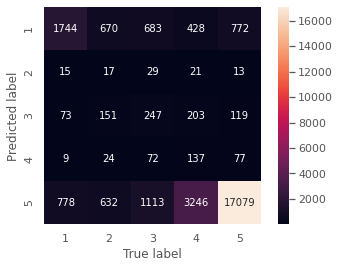

Accuracy:	0.678047
F1-score:	0.318372
Precision:	0.414652
Recall:		0.354424

Classification performance:
              precision    recall  f1-score   support

           0       0.41      0.67      0.50      2619
           1       0.18      0.01      0.02      1494
           2       0.31      0.12      0.17      2144
           3       0.43      0.03      0.06      4035
           4       0.75      0.95      0.83     18060

    accuracy                           0.68     28352
   macro avg       0.41      0.35      0.32     28352
weighted avg       0.61      0.68      0.60     28352



In [32]:
# Convolutional Neural Network 

# Plot the confusion matrix 
score_catagory_labels = [1, 2, 3, 4, 5]

matrix = confusion_matrix(test_labels_minus1, cnn_predictions_labels)
sns.heatmap(matrix.T, square = True, annot = True, fmt = "d", 
            xticklabels = score_catagory_labels, yticklabels = score_catagory_labels)
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.savefig("Figure_8_1.png")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_labels_minus1, cnn_predictions_labels))
print("F1-score:\t%f" % f1_score(test_labels_minus1, cnn_predictions_labels, average = "macro"))
print("Precision:\t%f" % precision_score(test_labels_minus1, cnn_predictions_labels, average = "macro"))
print("Recall:\t\t%f" % recall_score(test_labels_minus1, cnn_predictions_labels, average = "macro"))
print("\nClassification performance:\n%s" % classification_report(test_labels_minus1, cnn_predictions_labels))


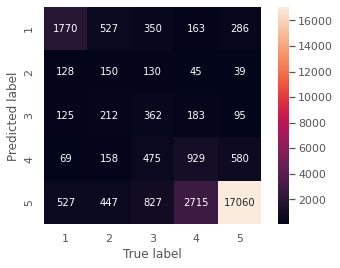

Accuracy:	0.714976
F1-score:	0.432152
Precision:	0.491594
Recall:		0.423988

Classification performance:
              precision    recall  f1-score   support

           0       0.57      0.68      0.62      2619
           1       0.30      0.10      0.15      1494
           2       0.37      0.17      0.23      2144
           3       0.42      0.23      0.30      4035
           4       0.79      0.94      0.86     18060

    accuracy                           0.71     28352
   macro avg       0.49      0.42      0.43     28352
weighted avg       0.66      0.71      0.67     28352



In [33]:
# Long Short-Term Memory model 

# Plot the confusion matrix 
score_catagory_labels = [1, 2, 3, 4, 5]

matrix = confusion_matrix(test_labels_minus1, lstm_predictions_labels)
sns.heatmap(matrix.T, square = True, annot = True, fmt = "d", 
            xticklabels = score_catagory_labels, yticklabels = score_catagory_labels)
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.savefig("Figure_9_1.png")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_labels_minus1, lstm_predictions_labels))
print("F1-score:\t%f" % f1_score(test_labels_minus1, lstm_predictions_labels, average = "macro"))
print("Precision:\t%f" % precision_score(test_labels_minus1, lstm_predictions_labels, average = "macro"))
print("Recall:\t\t%f" % recall_score(test_labels_minus1, lstm_predictions_labels, average = "macro"))
print("\nClassification performance:\n%s" % classification_report(test_labels_minus1, lstm_predictions_labels))


## Implementation - Task 7
Store the **four** trained models in files and implement a function `predict_food_review(text, model)` that given a <ins>text string</ins> (“`text`”) and model <ins>filename</ins> (“`model`”), it will load the pre-trained model, and predict the food review rating of the input text. The function should be able to work without requiring to rerun all or part of your code. (**10%**)

In [34]:
# Function works under the assumption that all the required packages above are loaded above 

def clean_text(text):
    """Function to clean text input to ensure input strings are processed in the same way as for 
    model train and test data."""
    
    # Note: code here is different to preprocessing in the main script as the latter is for processing whole 
    # pandas series and the former is individual stings. The results are identical. 
    
    # Check text input is a string 
    if (not isinstance(text, str)):
        
        raise Exception("text input is not a string.")
    
    # Transform text to all lowercase 
    text = text.lower()
    
    # Remove all "-", ".", "'" and replace with "" e.g. lower-case to lowercase, U.K to UK, don't to dont 
    text = re.sub(r"[-.']", "", text)
    
    # Replace html tags with " " 
    text = re.sub(r"<.+?>", " ", text)
    
    # Replace happy emojis with " happy " 
    text = re.sub(r"[:][)]|[(][:]", " happy ", text)
    
    # Replace sad emojis with " sad " 
    text = re.sub(r"[:][(]|[)][:]", " sad ", text)
    
    # Remove punctuation 
    text = re.sub(r"[^\w\s]", " ", text)
    
    return text


def predict_food_review(text, model):
    """Function to predict the Score (1 to 5) of a food review using pretrained Naive Bayes, k Nearest Neighbours, 
    Convolutional Neural Network, and Long Short-Term Memory models. Provide input text as a string. 
    Choose models from: "nb_model.pkl", "knn_model.pkl", "cnn_model.pkl", and "lstm_model.pkl"."""
    
    # Check text input is a string 
    if (not isinstance(text, str)):
        
        raise Exception("text input is not a string.")
        
    # Check model filename input is a string 
    if (not isinstance(model, str)):
        
        raise Exception("model filename input is not a string.")
        
    # Check a valid model filename input is provided 
    valid_model_filenames = ["nb_model.pkl", "knn_model.pkl", "cnn_model.pkl", "lstm_model.pkl"]
    
    if (not model in valid_model_filenames):
        
        raise Exception("model filename input is not a valid option. \nValid options include: \n'nb_model.pkl', 'kNN_model.pkl', 'cnn_model.pkl', and 'lstm_model.pkl'")
    
    # Clean text in the same way as for initial train and test 
    text = clean_text(text)
    
    # POS tag, remove stop words, and lemmatise in the same way as for initial train and test and return a list of lemmas 
    text = remove_stopwords_and_lemmatise(text)
    
    # Naive Bayes 
    if (model == "nb_model.pkl"):
        
        # Join lists of lemmas to string 
        text = " ".join(text)
        
        # Make text an element of a list - required for predict() 
        text = [text]
        
        # Load Naive Bayes model 
        with open("nb_model.pkl", "rb") as file:
            
            nb_model = pickle.load(file)
            
        # Returns np array 
        predicted_score = nb_model.predict(text)
        
        # Extract element from array and convert to string 
        predicted_score = str(predicted_score.item())
        
        return predicted_score
    
    # k Nearest Neighbours 
    if (model == "knn_model.pkl"):
        
        # Load word2vec word embeddings 
        w2v_word_embeddings_100 = Word2Vec.load("w2v_word_embeddings_100.model")
        
        # Vectorise text into a dense vector document representation 
        text = [text_to_single_vector(text, w2v_word_embeddings_100)]
        
        # Load k Nearest Neighbours 
        with open("knn_model.pkl", "rb") as file:
            
            knn_model = pickle.load(file)
            
        # Returns np array 
        predicted_score = knn_model.predict(text)
        
        # Extract element from array and convert to string 
        predicted_score = str(predicted_score.item())
        
        return predicted_score
        
    # Convolutional Neural Network 
    if (model == "cnn_model.pkl"):
        
        # Load word2vec word embeddings 
        w2v_word_embeddings_25 = Word2Vec.load("w2v_word_embeddings_25.model")
        
        # Vectorise text data into dense vector word representations 
        text = np.array([document_to_matrix(text, w2v_word_embeddings_25, 50)])
        
        # Load Convolutional Neural Network 
        with open("cnn_model.pkl", "rb") as file:
            
            cnn_model = pickle.load(file)
            
        # Returns np array 
        predicted_score = cnn_model.predict(text)
        predicted_score = np.argmax(predicted_score, axis = 1)
        
        # Extract element from array and convert to string 
        predicted_score = str(predicted_score.item() + 1) # Add 1 to turn 0 indexed predictions into 1-5 predictions 
        
        return predicted_score
    
    # Long Short-Term Memory model 
    if (model == "lstm_model.pkl"):
        
        # Load word2vec word embeddings 
        w2v_word_embeddings_25 = Word2Vec.load("w2v_word_embeddings_25.model")
        
        # Vectorise text data into dense vector word representations 
        text = np.array([document_to_matrix(text, w2v_word_embeddings_25, 50)])
        
        # Load Convolutional Neural Network 
        with open("lstm_model.pkl", "rb") as file:
            
            lstm_model = pickle.load(file)
            
        # Returns np array 
        predicted_score = lstm_model.predict(text)
        predicted_score = np.argmax(predicted_score, axis = 1)
        
        # Extract element from array and convert to string 
        predicted_score = str(predicted_score.item() + 1) # Add 1 to turn 0 indexed predictions into 1-5 predictions 
        
        return predicted_score
    

In [35]:
# TODO: Ensure final function loads correct model versions and remove all _1 and _2 versions from working directory 

## Report - Task 1
Critical discussion about the dataset (suitability, problems, class balance, etc.). (**6%**)

### Dataset

The food review dataset used for this report contained 3 features (columns) and 540,031 observations (rows), with 162,009 duplicate rows. The dataset was deemed large enough to undertake meaningful sentiment analysis with a large vocabulary of words in the dataset in theory allowing models trained on it to generalise well to unseen data. The dataset was large enough that both the space and time complexity of data processing and modelling needed to be carefully considered to prevent running out of memory and prohibitively long run times respectively. The datasets 3 features were "Score": the food review score, "Summary": a summary of the food review, and "Text" the food review itself. There were no missing values in the Score or Text columns. There were 27 missing values in the Summary column, however this was not assessed to be an issue as the primary columns required were Score and Text. There were no unexpected values in the Score column (only 1-5 scores), however there was class imbalance present with scores of 5 far more prevelant than other scores which could potentially bias models to the majority class, see Figure 1. The Text column contained raw text which had not been preprocessed or tokenised, containing: HTML tags, punctuation, emojis, capital letters, etc. 

While the potential problems detailed above could provide challenges for undertaking sentiment analysis, it was determined that with effective mitigation the dataset was suitable for undertaking the task of predicting food review scores. 

__Figure 1.__
![Figure 1.](Figure_1.png)


- Dataset has 3 features and 540,031 observations - this is large enough for meaningful sentiment analysis to be undertaken and large enough that the computational complexity of data processing and modelling methods needed to be considered to prevent prohibitively long run times. 
- No missing values in Score column. 
- No missing values in Text column. 
- 27 missing values in Summary column - this doesn't really matter though because we primarily care about Text and Score. 
- No unexpected values in the Score column - only 1, 2, 3, 4, 5. 
- Dataset has 162,009 duplicate rows. 
- The Text column contains raw text which is not tokenised or preprocessed: HTML tags and punctuation which need removed, emojis such as smiley faces which need removed or transformed, and raw text containing capital letters which needs to be lowercased. 
- Class imbalance with majority of observations with a Score of 5. 

## Report - Task 2
Description and justification of the data preparation step(s) used. (**6%**)

### Data Preparation

The dataset was deduplicated to prevent the erroneous repeated rows biasing models trained on the dataset. HTML tags were removed to reduce noise. Happy and sad emojis were tranformed into "happy" and "sad" to retain useful meaning post punctuation removal. "-", ".", and "'" were removed and replaced with "" to ensure consistency on the representation of words e.g. lower-case vs lowercase, U.K. vs UK, don't vs dont. All punctuation was then removed and replaced with " " and all text lowercased. All these processing steps were undertaken on the Summary and Text columns to reduce noise and non-useful information. This also reduces the computational complexity due to the denser vector representations achievable by not having repeated versions of words e.g. capitalised vs not. The Summary and Text columns were then concatenated, as from manual analysis is was determined that the Summary column also contained useful information regarding the sentiment of reviews. 

The text was then tokenised. Stop words were removed to reduce noise and remove potentially uninformative words. This also allowed for denser vector representations to make data processing and modelling less computationally intensive, while aiming to retain useful information. A trade-off was made here with the cost of reduced computational complexity being a potential reduction in models accuracy, e.g. the removal of certain stop words like "not" could mean models aren't able to capture important negation information. Penn Treeback Part of Speech (POS) tagging was then applied, with tags subsequently converted to simpler WordNet POS tags. This simplification could result in a reduction in models accuracy with only Nouns, Verbs, Adverbs, and Adjectives as classes for tagging, with other word types defaulted to Nouns. Words were then lemmatised to allow for denser vector representations to make data processing and modelling less computationally intensive while aiming to retain words general meanings, e.g. "eats", "eating" to "eat". 

The modelling presented in this report is able to be run for the entire datatset, however it takes a relatively long time to run so for the purposes of validating quickly on the NCC 25% of the datatset was subset using stratified random sampling to ensure a similar distribution as the original dataset. This subset was split into train and test sets for modelling using a 70/30 train/test split and stratified random sampling by Score to ensure both sets had a similar distribution of Score values. Given the size of the dataset simple random sampling did generally provide similar distributions of Score values in the train and test set but it was decided it was better to guarentee a representative split. 

The lemmatised text was then used to calculate each of the different word or document embeddings used as inputs for the various models in this report, detailed below. 


- Deduplication to prevent the data biasing the models due to erroneous repeated rows. 
- HTML tag removal, emoji transformation into words, lowercasing, -, ., and ' removal with no space, and punctuation removal to remove noise and non-useful information from the Text. This helps computationally because it will lead to denser vector representations of the text due to not repeating capitalised vs not versions of words etc. This was undertaken on both Summary and Text columns. 
- The Summary and Text columns were concatenated as from manual checking it was determined that the Summary column also contained useful information regarding the sentiment of reviews. 
- The text was then tokenised. 
- Stop words were removed to remove noise / potentially uniformative words and to create denser vectors making the processing and modelling less computationally intesive, given the relatively large dataset. A standard set of English stopwords was used from the NLTK package. There is potentially some drop in modelling accuracy in exchange for the reduced computational complexity as words such as "not", "wasn't" etc. were removed which could negate positive words and change the sentiment of reviews. 
- Penn Treeback POS tagging was then applied with tags subsequently converted to simpler WordNet POS tags. This simplification could result in a reduction in accuracy with only Nouns, Verbs, Adverbs, and Adjectives as classes for tagging and if no mapping was available words were defaulted to Nouns. 
- Words were then lemmatised to create denser vectors making the processing and modelling less computationally intesive, given the relatively large dataset. 
- Further processing of the tokenised / lemmatised text was then undertaken for the different representations used by the different models, with this processing detailed below. 

## Report - Task 3
Description and commentary on the machine learning architectures used, including a description and justification of the text representation method(s) used. (**7%**)

### Machine Learning Models

#### Naive Bayes 



#### k Nearest Neighbours 



#### Convolutional Neural Network 



#### Long Short-Term Memory Model 




#### Naive Bayes 

- Term Frequency-Inverse Document Freuency (TF-IDF) vector word embedding was used due to its compatibility with Naive Bayes, with each document represented as a vector and each vector element representing a specific words TF-IDF score. TF-IDF weights words based on how often they appear across all documents allowing the Naive Bayes model to focus on terms which should be more impactful in predicting the sentiment of a review and reducing the impact of common words which should be less impactful. 
- Multinomial Naive Bayes was chosen given the 5 classes for prediction. 
- Laplace Smoothing was used to address the problem of zero probabilities and 5-fold cross-validation was used to choose the best alpha value, using accuracy as the performance metric compared. This helped prevent the model from predicting almost exclusively scores of 5 due to the class imbalance in the dataset. 

#### k Nearest Neighbours 

- Word2Vec Continuous Bag of Words word embedding was used to create 300 dimensional dense vector representations of each word and then these were used to create dense vector representations of each review (document). Each word was transformed into a 300 length vector representation, 300 was chosen as a trade-off between capturing as much information as possible about each word and the added computational complexity of higher dimensional vectors. The context window was chosen as 5 to capture the context of the 5 words either side of any specific word to learn from. The dense vector representations for the words in a review were then averaged to get a dense document representation (300 dimensional vector) to capture the average sentiment in each review. A single document representation was chosen given that it reduces the computational complexity when using k Nearest Neighbours relative to sparse vector representation or dense vector representation per word formats. 
- 5-fold cross-validation was used to choose the best value of k (from 1, 3, 5, 7), using accuracy as the performance metric compared. A k value of 7 was determined to have the highest average accuracy in cross-validation, see Figure 2. 

__Figure 2.__
![Figure 2.](Figure_2.png)

#### Convolutional Neural Network 

- Word2Vec Continuous Bag of Words word embedding was used to created 50 dimensional dense vector representations of each word and then these were used to create a matrix of dense vector word representations for each review (50 by 50). 50 diminsions was chosen to reduce the space complexity of the Word2Vec embeddings and to reduce the time complexity for model training. The distribution of words per review was analysed and it was determined that 50 words would capture all the words in just under 75% or all reviews, see Figure 3. Matrices for reviews with less than 50 words were padded with zeros and reviews with more than 50 words were truncated to 50 to ensure that the matrix representations for all reviews had the same dimensions. This was determined to be a good trade-off between the amount of information able to be captured in each review matrix and the increased space and time complexity of larger matrices. 

__Figure 3.__
![Figure 3.](Figure_3.png)

- The model arhcitecture used a 50 by 50 input shape feeding into a 1-dimensional convolutional layer with a filter size of 128, kernal size of 5 and ReLU activation function. The layer is designed to capture local patterns in the input with a 5 word context window and the 128 node filter size was chosen as a trade-off between being able to capture complex patterns in the data and computational complexity. A 1-dimensional max pooling layer follows to try and abstract the features extracted by the previous layer and prevent overfitting. A 1-dimensional convolutional layer identical to the first follows to try and further refine the features extracted from the input. A 1-dimensional global max pooling layer follows to reduce the dimensionality before connecting to the following dense layer which interprets the feature extracted and pooled by previous layers and contains 128 nodes and uses the ReLu activation function. All ReLU activation functions used are to introduce non-linearity to the model to allow it to capture non-linear relationships and ReLU is more computationally efficient than other non-linear options. The output layer is a dense layer with 5 nodes corresponding to the number of classes with a softmax activation function used to output the probability distribution over the 5 classes. 
- The loss function used was sparse categorical cross entropy due to the multi-class nature of the classification problem and the mutually expclusive classes. 
- The Adam optimiser was used as it is conventional and computationally efficient. 
- A 70/30 train/validation split was used for model training with a stoping condition on no accuracy improvement for 3 epochs to prevent unneccassary computation. 
- Accuracy was chosen as the performance metric for model training, however given the class imbalance present repeating the analysis using F1-Score might be worthwhile. 

#### Long Short-Term Memory Model 

- The same Word2Vec Continuous Bag of Words 50 by 50 matrices of dense vector word representations for reviews was used as described in the Convolutional Neural Network section for the same reasons described. 
- 


## Report - Task 4
Detailed performance evaluation of the trained machine learning models in terms of the computed performance metrics. (**5%**)

#### Naive Bayes 

__Figure 6.A__
![Figure 6.](Figure_6.png)

__Table 1.A__

| Performance Metric | Score |
|----------|----------|
| Accuracy: | 0.68 |
| F1-Score: | 0.31 |
| Precision: | 0.49 |
| Recall: | 0.30 |

Note: Macro-averaging used for F1-Score, Precision, and recall. 

Naive Bayes had an overall accuracy of 0.68, however this is due to the model primarily predicting Scores of 5 and the test dataset having majority 5 Scores. The model predicts 5 the majority of the time despite the true class and this is reflected in the low recall score 

__Figure 6.B__
![Figure 6.B](Figure_6_1.png)

__Table 1.B__

| Performance Metric | Score |
|----------|----------|
| Accuracy: | 0.67 |
| F1-Score: | 0.29 |
| Precision: | 0.47 |
| Recall: | 0.29 |

Note: Macro-averaging used for F1-Score, Precision, and recall. 

- Same hyperparameters and text representation for both. 
- First one ran on full dataset. 

#### k Nearest Neighbours 

__Figure 7.A__
![Figure 7.A](Figure_7.png)

__Table 2.A__

| Performance Metric | Score |
|----------|----------|
| Accuracy: | 0.66 |
| F1-Score: | 0.37 |
| Precision: | 0.40 |
| Recall: | 0.36 |

Note: Macro-averaging used for F1-Score, Precision, and recall. 

__Figure 7.B__
![Figure 7.B](Figure_7_1.png)

__Table 2.B__

| Performance Metric | Score |
|----------|----------|
| Accuracy: | 0.64 |
| F1-Score: | 0.35 |
| Precision: | 0.38 |
| Recall: | 0.34 |

Note: Macro-averaging used for F1-Score, Precision, and recall. 

- Same hyperparameters. 
- First has 300 dimensional vector document representations and second has 100 dimensional. 
- First one ran on full dataset. 

#### Convolutional Neural Network 

__Figure 8.A__
![Figure 8.A](Figure_8.png)

__Table 3.A__

| Performance Metric | Score |
|----------|----------|
| Accuracy: | 0.71 |
| F1-Score: | 0.41 |
| Precision: | 0.49 |
| Recall: | 0.41 |

Note: Macro-averaging used for F1-Score, Precision, and recall. 

__Table 3.B__

| Performance Metric | Score |
|----------|----------|
| Accuracy: | 0.68 |
| F1-Score: | 0.32 |
| Precision: | 0.41 |
| Recall: | 0.35 |

Note: Macro-averaging used for F1-Score, Precision, and recall. 

- Same hyperparameters. 
- First has 50 by 50 matrix document representations and second has 50 by 25. 
- First one ran on full dataset. 

__Figure 8.B__
![Figure 8.B](Figure_8_1.png)

#### Long Short-Term Memory Model 

__Figure 9.A__
![Figure 9.A](Figure_9.png)

__Table 4.A__

| Performance Metric | Score |
|----------|----------|
| Accuracy: | 0.74 |
| F1-Score: | 0.50 |
| Precision: | 0.55 |
| Recall: | 0.49 |

Note: Macro-averaging used for F1-Score, Precision, and recall. 

__Figure 9.B__
![Figure 9.B](Figure_9_1.png)

__Table 4.B__

| Performance Metric | Score |
|----------|----------|
| Accuracy: | 0.71 |
| F1-Score: | 0.43 |
| Precision: | 0.49 |
| Recall: | 0.42 |

Note: Macro-averaging used for F1-Score, Precision, and recall. 

- Same hyperparameters. 
- First has 50 by 50 matrix document representations and second has 50 by 25. 
- First one ran on full datatset. 

EXPLAIN THIS IS THE BEST MODEL BUT VERY COMPUTATIONALLY INTENSIVE 

## Report - Task 5
Critical discussion on the achieved results, including potential limitations and usage instructions/suggestions. (**6%**)

Potential improvements:

- Using a class balanced trianing set and testing on the test set 
- Using F1-Score for model selection?
- Increasing the number of nodes per layer in NNs 
- Including negation stop words to see if it increases performance 